### This code records, compiles, and computes $C_A$, $C_{N_y}$, and $C_{N_z}$ for the ___ launch vehicle ###

Imports

In [2]:
import numpy as np
from ksp_interface import GuidanceHelperFunctions as ghf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import krpc
import json
import time

Connect to KRPC server, set vessel, set refference frame

In [3]:
conn = krpc.connect(name='KRPC Test')
print(conn.krpc.get_status().version)
vessel = conn.space_center.active_vessel
# refframe = conn.space_center.bodies['Kerbin'].reference_frame #Centered on Kerbin CoM, x towards 0-0.
refframe = conn.space_center.bodies['Kerbin'].non_rotating_reference_frame # This doesn't seem to work any better really
kerbin = conn.space_center.bodies['Kerbin']

0.5.4


Setup streams for position, velocity, direction, aerodynamic forces, ect

In [4]:
stream_dict = {
    'ut': (getattr, conn.space_center, 'ut'),
    'position': (vessel.position, refframe),
    'velocity': (vessel.velocity, refframe),
    'direction': (vessel.direction, refframe),
    'aerodynamic_force': (getattr, vessel.flight(refframe), 'aerodynamic_force'),
    'mean_altitude': (getattr, vessel.flight(), 'mean_altitude'),
}
session = (conn, vessel, refframe)
streams = ghf.start_streams(session, stream_dict = stream_dict)

Create functions for simulated aerodynamic forces

In [5]:
def sim_aero():
    sim_aero = vessel.flight(refframe).simulate_aerodynamic_force_at(kerbin, streams['position'](), streams['velocity']())
    return np.array(sim_aero)

def aero_error():
    cur_aero = np.array(streams['aerodynamic_force']())
    return cur_aero - sim_aero()


Create drawer and register vectors

In [5]:
drawer = ghf.VectorDrawer(session, streams, scale=1, normalize=True)
drawer.register_vector("velocity", lambda: np.array(streams['velocity']()), normalize=True, scale=10, labels="vel")
drawer.register_vector("direction", lambda: np.array(streams['direction']()), normalize=True, scale=10, labels="dir")
drawer.register_vector("aerodynamic_force", lambda: np.array(streams['aerodynamic_force']()), normalize=True, scale=10, labels="aero_force",colors=(1, 0, 0))
drawer.register_vector("sim_aero", sim_aero, normalize=True, scale=10, labels="sim_aero")
drawer.register_vector("error", aero_error, normalize=False, scale=0.001, labels="error")

Start automatic drawing

In [6]:
drawer.start_drawing(dt=0.01)

Automatic vector updating started.


Stop automatic drawing

In [7]:
drawer.stop_drawing()

Automatic vector updating stopped and vectors cleared.


Draw once

In [28]:
drawer.clear_vectors()
drawer.draw_vectors()

Perform automatic, repeatable flight.

In [6]:
filename = 'flight_data/restock_aerodynamics'
recorder = ghf.Recording(session, streams)
recorder.register_stream_func('sim_aero', sim_aero)
recorder.register_stream_func('aero_error', aero_error)

# Pre-launch setup
vessel.control.sas = False
vessel.control.rcs = False
vessel.control.throttle = 1.0

# Activate the first stage
vessel.auto_pilot.disengage()
vessel.auto_pilot.target_pitch_and_heading(90, 90)
vessel.control.activate_next_stage()
time.sleep(3)
recorder.start_recording(dt=0.25)
vessel.auto_pilot.engage()
vessel.auto_pilot.target_pitch_and_heading(90, 90)
time.sleep(10)
vessel.auto_pilot.target_pitch_and_heading(45, 90)
time.sleep(10)
vessel.auto_pilot.target_pitch_and_heading(45, 45)
time.sleep(10)
vessel.auto_pilot.target_pitch_and_heading(90, 90)
time.sleep(10)
vessel.auto_pilot.target_pitch_and_heading(135, 135)
time.sleep(10)
vessel.auto_pilot.target_pitch_and_heading(90, 90)
time.sleep(10)
recorder.stop_recording()
recorder.save_recording(filename=filename, format='json')

Automated recording started.
Automated recording stopped.
Recording saved to flight_data/restock_aerodynamics.json


Stop streams

In [7]:
ghf.stop_streams(streams)

Analyze data!

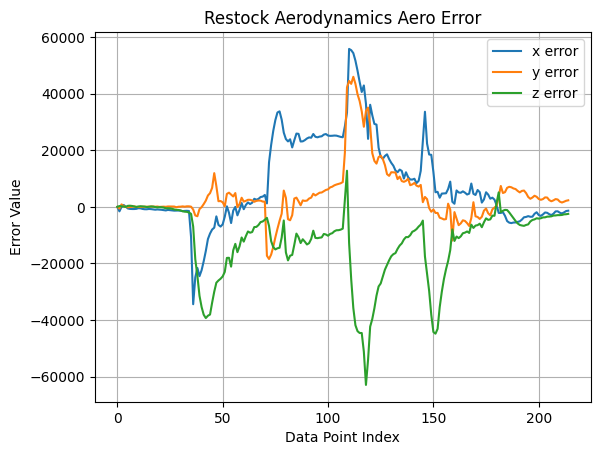

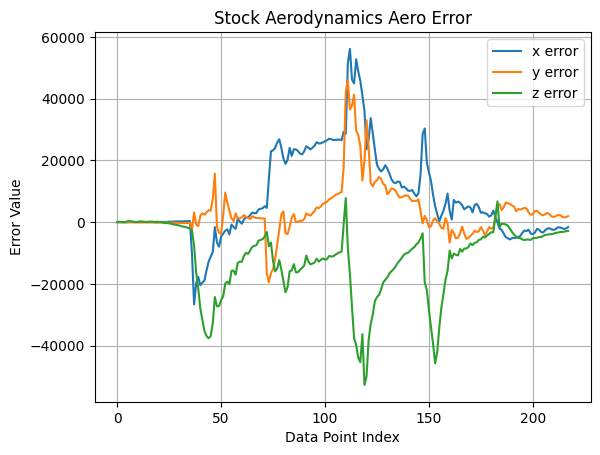

In [8]:
def plot_aero_error(json_path, title):
    # Load JSON data
    with open(json_path, 'r') as f:
        data = json.load(f)
    # Convert aero_error to numpy array
    error = np.array(data['aero_error'])
    x = error[:, 0]
    y = error[:, 1]
    z = error[:, 2]
    
    # Create plot
    plt.figure()
    plt.plot(x, label='x error')
    plt.plot(y, label='y error')
    plt.plot(z, label='z error')
    plt.xlabel('Data Point Index')
    plt.ylabel('Error Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)

# Plot for both datasets
plot_aero_error('flight_data/restock_aerodynamics.json', 'Restock Aerodynamics Aero Error')
plot_aero_error('flight_data/stock_aerodynamics.json', 'Stock Aerodynamics Aero Error')

# Display all figures
plt.show()

In [9]:
def vector_rmse_with_axes(json_path):
    """
    Calculates the overall vector RMSE and per-axis RMSE
    from 'aerodynamic_force' and 'sim_aero' arrays in the JSON.
    """
    # Load JSON data
    with open(json_path, 'r') as f:
        data = json.load(f)
    # Convert to NumPy arrays
    aero_force = np.array(data['aerodynamic_force'])
    sim_aero   = np.array(data['sim_aero'])
    # Compute error vectors
    error = aero_force - sim_aero

    # Overall vector RMSE: sqrt(mean(sum(error_i^2)))
    sq_mags     = np.sum(error**2, axis=1)
    vector_rmse = np.sqrt(np.mean(sq_mags))

    # Per-axis RMSE: sqrt(mean(error[:,axis]^2))
    rmse_x = np.sqrt(np.mean(error[:, 0]**2))
    rmse_y = np.sqrt(np.mean(error[:, 1]**2))
    rmse_z = np.sqrt(np.mean(error[:, 2]**2))

    return vector_rmse, rmse_x, rmse_y, rmse_z

# Paths to your datasets
datasets = {
    'Restock': 'flight_data/restock_aerodynamics.json',
    'Stock':   'flight_data/stock_aerodynamics.json'
}

# Compute and display RMSE values
for name, path in datasets.items():
    vec_rmse, rmse_x, rmse_y, rmse_z = vector_rmse_with_axes(path)
    print(f"{name} dataset:")
    print(f"  Overall Vector RMSE: {vec_rmse:.6f}")
    print(f"  RMSE X-axis:         {rmse_x:.6f}")
    print(f"  RMSE Y-axis:         {rmse_y:.6f}")
    print(f"  RMSE Z-axis:         {rmse_z:.6f}\n")

Restock dataset:
  Overall Vector RMSE: 26763.561226
  RMSE X-axis:         17029.436335
  RMSE Y-axis:         10856.632469
  RMSE Z-axis:         17561.891671

Stock dataset:
  Overall Vector RMSE: 25009.078221
  RMSE X-axis:         16355.955701
  RMSE Y-axis:         9446.737607
  RMSE Z-axis:         16391.944826

